# Clustering by K-mean

This notebook aims at clustering data by applying the K-mean algorithm. Note that the image representations are found by using the first layers of a Resnet which was pre-trained on the imagenet dataset. 

In [11]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import time
import os
import copy
import visdom
import pandas as pd
from math import ceil
from PIL import Image
from sklearn.cluster import KMeans
import shutil
from sklearn.decomposition import PCA


plt.ion()   # interactive mode

In [2]:
path_dr_f_d = '../Datasets/doctor_nurse/dr/fem_dr_dark_56/'
path_dr_f_l = '../Datasets/doctor_nurse/dr/fem_dr_light_256/'
path_dr_m_d = '../Datasets/doctor_nurse/dr/mal_dr_dark_62/'
path_dr_m_l = '../Datasets/doctor_nurse/dr/mal_dr_light_308/'

dr_f_d = os.listdir(path_dr_f_d)
dr_f_l = os.listdir(path_dr_f_l)
dr_m_d = os.listdir(path_dr_m_d)
dr_m_l = os.listdir(path_dr_m_l)

path_nur_f_d = '../Datasets/doctor_nurse/nurse/fem_nurse_dark_63/'
path_nur_f_l = '../Datasets/doctor_nurse/nurse/fem_nurse_light_252/'
path_nur_m_d = '../Datasets/doctor_nurse/nurse/mal_nurse_dark_76/'
path_nur_m_l = '../Datasets/doctor_nurse/nurse/mal_nurse_light_203/'

nur_f_d = os.listdir(path_nur_f_d)
nur_f_l = os.listdir(path_nur_f_l)
nur_m_d = os.listdir(path_nur_m_d)
nur_m_l = os.listdir(path_nur_m_l)

dr_m, dr_f = len(dr_m_d) + len(dr_m_l), len(dr_f_d) + len(dr_f_l)

w_protected = 4

###  Defining dataloaders

In [3]:
class my_ImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform):
        super().__init__(root, transform)
        
    def __getitem__(self, index: int):
        return super().__getitem__(index), index

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


BIAS = 0.8
data_dir = '../Datasets/doctor_nurse/train_test_split'
image_datasets = {x: my_ImageFolder(os.path.join(data_dir, f"train_{BIAS}" if x=="train" and BIAS else x), data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

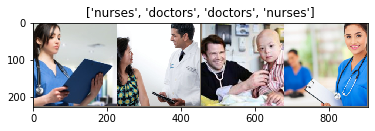

tensor([345,   8, 280, 395])


In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
(inputs, classes), index = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
print(index)

### Freezing all layers except last FC

For descirption of architecture of resNet, see: https://arxiv.org/pdf/1512.03385.pdf

In [6]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

#### Finding representations

#### Using representations

In [7]:
X_transform, labels, indexes = np.array([[]]).reshape(0,1000), np.array([]).astype(int), np.array([]).astype(int)
for i, ((inputs, label), index) in enumerate(dataloaders["train"]):
    output = model_conv(inputs)
    X_transform = np.concatenate([X_transform, output])
    indexes = np.concatenate([indexes, index.numpy().reshape(-1)])
    labels = np.concatenate([labels, label.numpy().reshape(-1)])

/home/ghayat/.local/lib/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


#### Using images

In [147]:
X_transform, labels, indexes = np.array([[]]).reshape(0,224, 224), np.array([]).astype(int), np.array([]).astype(int)
for i, ((inputs, label), index) in enumerate(dataloaders["train"]):
    X_transform = np.concatenate([X_transform, np.mean(inputs.numpy(), axis=1)])
    indexes = np.concatenate([indexes, index.numpy().reshape(-1)])
    labels = np.concatenate([labels, label.numpy().reshape(-1)])

/home/ghayat/.local/lib/python3.6/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## K-mean algorithm

In [8]:
def view_clusters(path, kmeans, labels, indexes):
    K = len(set(kmeans))
    dr, nur = os.listdir(os.path.join(path, "doctors")), os.listdir(os.path.join(path, "nurses"))
    
    paths = []
    for k in range(K):
        paths.append(f"clustering_{K}/cluster_{k}")
        os.makedirs(paths[-1], exist_ok=True)
        
    for i in range(len(kmeans)):
        src = os.path.join(path, "doctors/" if not labels[i] else "nurses/") + (dr[indexes[i]] if not labels[i] else nur[indexes[i] - len(dr)])
        dst = f"clustering_{K}/cluster_{kmeans[i]}/" + (dr[indexes[i]] if not labels[i] else nur[indexes[i] - len(dr)])
        shutil.copy(src, dst)
    
    return paths

def statistics(path, clusters):
    K = len(set(clusters))
    dr, nur = os.listdir(os.path.join(path, "doctors")), os.listdir(os.path.join(path, "nurses"))
    
    for k in range(K):
        n_dr, n_nur, n_m, n_f = 0, 0, 0, 0
        cluster = os.listdir(clusters[k])
        for img in cluster:
            if img in set(dr_f_d + dr_f_l + dr_m_d + dr_m_l):
                n_dr += 1
            else:
                n_nur += 1
                
            if img in set(dr_f_d + dr_f_l + nur_f_d + nur_f_l):
                n_f += 1
            else:
                n_m += 1  
                
        print(f"Cluster {k} -> number of samples: {len(cluster)}, number of doctors: {n_dr} ({n_dr/len(cluster)*100:.1f}%), number of nurses: {n_nur} ({n_nur/len(cluster)*100:.1f}%), number of males: {n_m} ({n_m/len(cluster)*100:.1f}%), number of females: {n_f} ({n_f/len(cluster)*100:.1f}%)")

### Clustering

In [12]:
kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(X_transform.reshape((X_transform.shape[0], -1)))

#### PCA reduction

In [9]:
X_reducted = PCA(n_components=2).fit_transform(X_transform)
kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(X_reducted.reshape((X_reducted.shape[0], -1)))

In [152]:
cluster_paths = view_clusters(os.path.join(data_dir, "train_0.8"), kmeans, labels, indexes)

### Statistics

In [153]:
statistics(os.path.join(data_dir, "train_0.8"), cluster_paths)

Cluster 0 -> number of samples: 306, number of doctors: 186 (60.8%), number of nurses: 120 (39.2%), number of males: 161 (52.6%), number of females: 145 (47.4%)
Cluster 1 -> number of samples: 305, number of doctors: 148 (48.5%), number of nurses: 157 (51.5%), number of males: 161 (52.8%), number of females: 144 (47.2%)


## Vizualization

In [29]:
cluster_1 = np.array([X_reducted[i, :] for i in range(len(kmeans)) if not kmeans[i]])
cluster_2 = np.array([X_reducted[i, :] for i in range(len(kmeans)) if kmeans[i]])

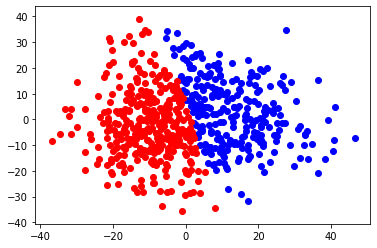

In [38]:
plt.scatter(x = cluster_1[:,0], y = cluster_1[:,1], c='Blue')
plt.scatter(x = cluster_2[:,0], y = cluster_2[:,1], c='Red')
plt.show()